# Temperature Map
### Plotting Temperatures 3 ways:
1) Cartoply contourplot
2) Matplotpib point plot     
3) Bokhey point plot         

1) is maybe done!
2) is maybe done, but not sure if I like it     
3) is least far along, struggling     

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

In [2]:
import cartopy.feature as cf 

In [33]:
import matplotlib.cm as cm

In [3]:
import geopandas

In [4]:
from bokeh.plotting import figure, show 
from ipywidgets import interact
from bokeh.models import HoverTool
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

## to do
* Lost some points when I subset the spatial data so only plots over the US (not ocean etc), get those back -I got them back on the Northern boarder, not a pretty solution. Still missing two points on the map.
* Interactive plot



In [5]:
#date = '2020-12'
#df = pd.read_csv('{} temperature.csv'.format(date))
data_folder = 'Data'
filename = '2020-12 temp and wind.csv'
file = os.path.join(data_folder, filename)

#df = pd.read_csv('12-2020 temp and wind.csv')
df = pd.read_csv(file)

## Contourform Map

In [107]:
def contouform_map(df, values, title, date, colors):
    '''values: the column name to use for temperature values
        title: what is in that column (for the plot title)
        date: month and year of the data (for the plot title)
    '''
    #https://stackoverflow.com/questions/24032282/create-contour-plot-from-pandas-groupby-dataframe
    df_pivoted = df.pivot(index = 'lat', columns = 'lon', values = values)
    df_pivoted.columns
    X=df_pivoted.columns#.levels[1].values
    Y=df_pivoted.index.values
    Z=df_pivoted.values
    lon,lat = np.meshgrid(X, Y)
    
    fig = plt.figure(figsize=(20,18)) #12,10
    ax = plt.axes(projection=ccrs.Mercator())

    extent = (X.min(), X.max(), Y.min(), Y.max()-3.6) #the Y-max is greater than the data?! (does this mean there's a problem?)
    ax.set_extent(extent)
    #ax.set_extent([-400,-180,25,377])
    ax.coastlines(resolution="110m",linewidth=0.7)
    ax.add_feature(cf.STATES, linewidth = 0.7)
    # https://coderzcolumn.com/tutorials/data-science/cartopy-basic-maps-scatter-map-bubble-map-and-connection-map 

    testcol = []
    testnorm = []

    for i in df[values]:
        if round(i,0) in colors.keys():
            testnorm.append(round(i,0))

    norms = sorted(list(set(testnorm)))  


    
    #deal with boundries (e.g min of 9 F needs to go to 0, max of 61F needs to go to 70)
    if df[values].min()<norms[0]:
        norms = [round(df[values].min()-5, -1)] + norms
    
    if df[values].max()>norms[-1]:
        norms.append(round(df[values].max()+4, -1))
   
    #get colors from the colors dict
    for i in norms:
        testcol.append(colors[i])   
    
    cmap = ListedColormap(testcol)
    norm = BoundaryNorm(norms, cmap.N)
    
    
    plt.contourf(lon, lat, Z, transform=ccrs.PlateCarree(), levels = len(norms)-1,
                 cmap=cmap, norm = norm, legend = True)
    plt.title('{} (F) 8:30AM-3:30PM {}'.format(title, date), size=22)
    cb = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, 
                      orientation="vertical", pad=0.02, aspect=16, shrink=0.5)
    cb.set_label('F',size=18,rotation=0,labelpad=15)
    cb.ax.tick_params(labelsize=15)
    #ax.spines['top'].set_visible(False) #doesn't work
    #plt.show()
    plt.savefig('{} (F) 8:30AM-3:30PM {}'.format(title, date))
    


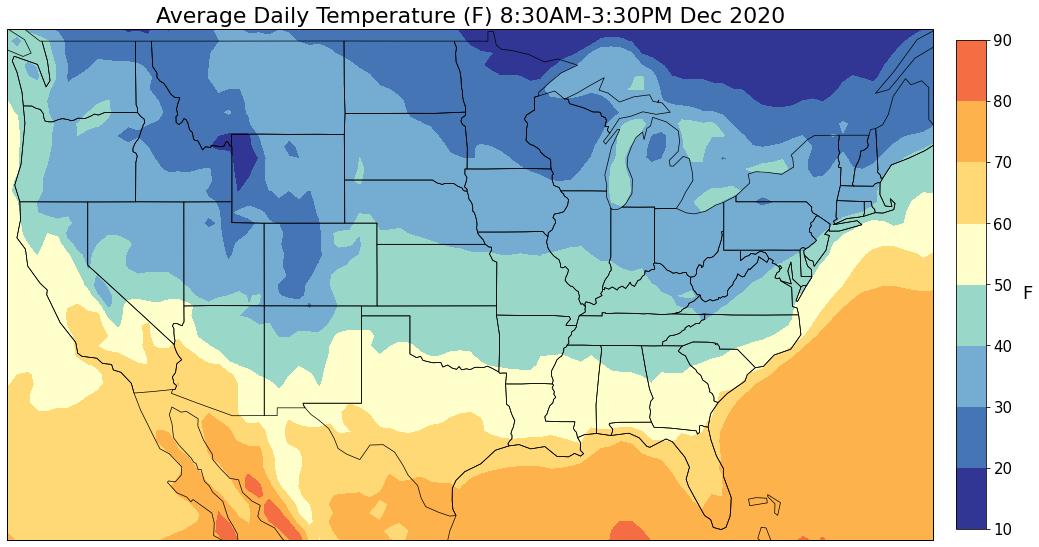

In [108]:
contouform_map(df, 'average_temp', 'Average Daily Temperature', 'Dec 2020', colors)

In [60]:
#this issue was teh levels argument -I was alowing it at defaulte!
def test_cont_plot(df, values, title, date):
    df_pivoted = df.pivot(index = 'lat', columns = 'lon', values = values)
    df_pivoted.columns
    X=df_pivoted.columns#.levels[1].values
    Y=df_pivoted.index.values
    Z=df_pivoted.values
    lon,lat = np.meshgrid(X, Y)
    
    fig = plt.figure(figsize=(12,10))
    ax = plt.axes(projection=ccrs.Mercator())

    extent = (X.min(), X.max(), Y.min(), Y.max()-3.5) #the Y-max is greater than the data?! (does this mean there's a problem?)
    ax.set_extent(extent)
    #ax.set_extent([-400,-180,25,377])
    ax.coastlines(resolution="110m",linewidth=1)
    ax.add_feature(cf.STATES)
    # https://coderzcolumn.com/tutorials/data-science/cartopy-basic-maps-scatter-map-bubble-map-and-connection-map 

    testcol = []
    testnorm = []

    for i in df[values]:
        if round(i,0) in colors.keys():
            testnorm.append(round(i,0))

    norms = sorted(list(set(testnorm)))  
   
    plt.contourf(lon, lat, Z, transform=ccrs.PlateCarree(), levels = 9)
    plt.title('{} (F) 8:30AM-3:30PM {}'.format(title, date), size=15)
    cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.55)
    cb.set_label('F',size=14,rotation=0,labelpad=15)
    cb.ax.tick_params(labelsize=10)
    #ax.spines['top'].set_visible(False) #doesn't work
    plt.show()

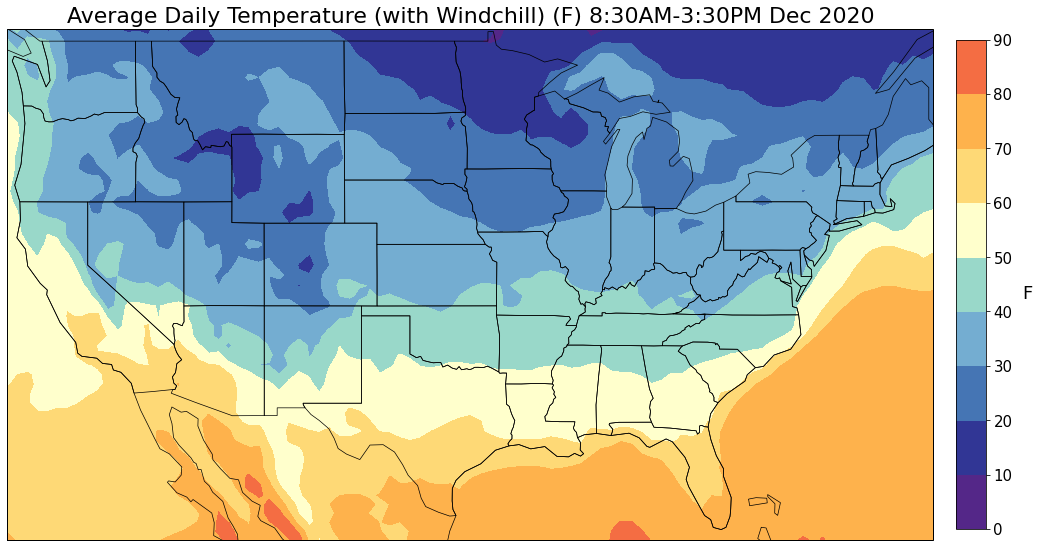

In [109]:
contouform_map(df, 'average_windchill', 'Average Daily Temperature (with Windchill)', 'Dec 2020', colors)

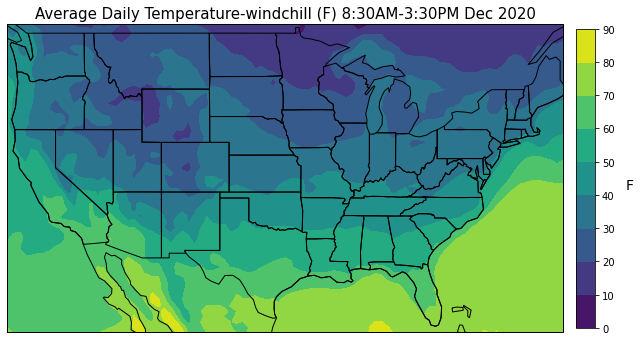

In [61]:
test_cont_plot(df, 'average_windchill', 'Average Daily Temperature-windchill', 'Dec 2020')

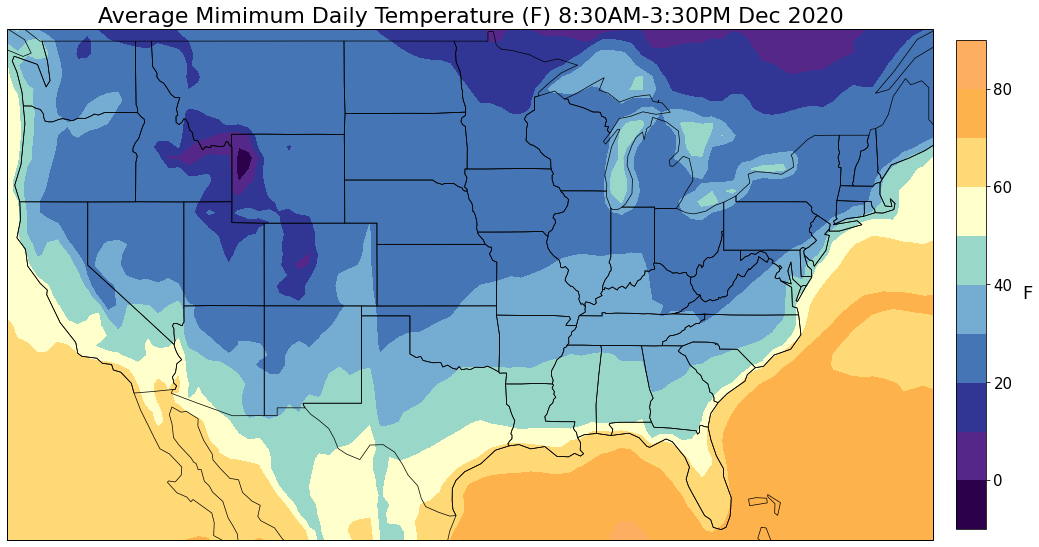

In [110]:
contouform_map(df, 'average_min_daily_temp', 'Average Mimimum Daily Temperature', 'Dec 2020', colors)

## Point plot

In [6]:
gdf = geopandas.GeoDataFrame(df, 
                             geometry=geopandas.points_from_xy(df['lon'], df['lat']),
                             crs = 'epsg:4269') #crs for North America

In [122]:
gdf.columns

Index(['Unnamed: 0', 'lat', 'lon', 'average_temp', 'average_min_daily_temp',
       'min_min_daily_temp', 'average_windchill',
       'average_min_daily_windchill', 'min_min_daily_windchill', 'geometry'],
      dtype='object')

In [7]:
#from https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html
#can also get school districts here!
state_file = os.path.join(data_folder, 'cb_2019_us_state_20m/cb_2019_us_state_20m.shp')
state = geopandas.read_file(state_file)

In [8]:
#https://stackoverflow.com/questions/19960077/how-to-filter-pandas-dataframe-using-in-and-not-in-like-in-sql
state_abres = ['AK', 'PR', 'HI']
contenental_states = state[~state['STUSPS'].isin(state_abres)]
#state_test.head()

In [249]:
#plt.ion()
#plt.ioff()
#%matplotlib notebook

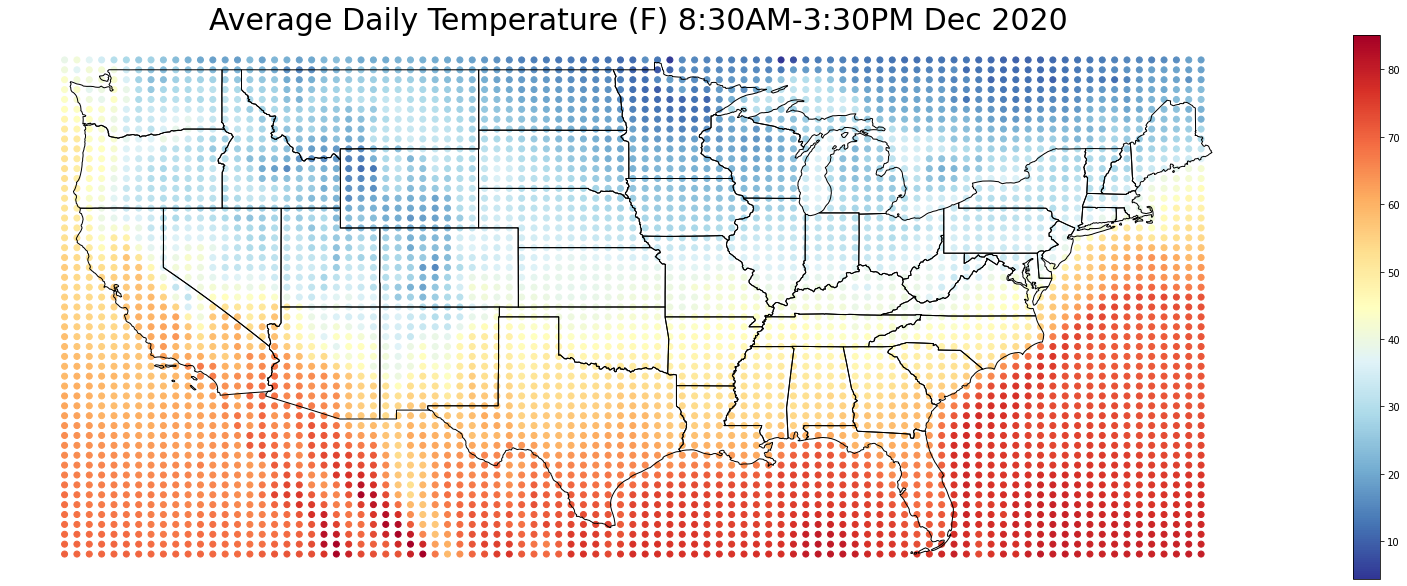

In [9]:
fig, ax = plt.subplots(figsize=(30,10))
#contenental_states.plot(ax=ax, color = 'none', edgecolor='black')
gdf.plot(ax=ax, column = 'average_windchill', cmap = 'RdYlBu_r', legend=True)
contenental_states.plot(ax=ax, color = 'none', edgecolor='black')

ax.axis('off')
ax.set_title('Average Daily Temperature (F) 8:30AM-3:30PM Dec 2020',
            size=30);
plt.show()

In [11]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
US = world[world.name == 'United States of America'] 

In [127]:
print(US.crs)
print(gdf.crs)

{'init': 'epsg:4326'}
epsg:4269


In [12]:
US_2 = US.to_crs(epsg=4269)

In [13]:
print(US_2.crs)
print(gdf.crs)
#doesnt' help

{'init': 'epsg:4269', 'no_defs': True}
epsg:4269


In [14]:
# https://stackoverflow.com/questions/63369715/filter-a-geopandas-dataframe-within-a-polygon-and-remove-from-the-dataframe-the
gdf['withinQ'] = "" #add empty column

withinQlist = []
for i in range(len(gdf)):
    withinQ = gdf['geometry'][i].within(US['geometry'].values[0])
    #print( withinQ )
    withinQlist.append(withinQ)
       

# update values in the that column, values: True/False
gdf['withinQ'] = withinQlist

# Cludge to get the missing points on the Northern border
for i in range(len(gdf)):
    if round(gdf['lat'][i],1) == 49.0 and round(gdf['lon'][i],1) > -122.6 and round(gdf['lon'][i],1) < -94.1:
        #print(round(gdf['lat'][i],0))
        gdf['withinQ'][i] = True

/Users/Sarah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
constricted_gdf = gdf[gdf['withinQ']==True]

In [16]:
from matplotlib.colors import ListedColormap, BoundaryNorm

In [17]:
#colors = {-10.0: '#4d004b', 0.0:'#3f007d',10.0:'#08519c', 
 #         20.0:'#4292c6',30.0:'#9ecae1',
  #        40.0:'#99d8c9', 50.0:'#ffffcc', 60.0:'#fed976', 
   #       70.0:'#feb24c', 80.0:'#fd8d3c', 90.0:'#fc4e2a'}


#70.0: '#fee090',
#60.0: '#ffffbf',
#50.0: '#e0f3f8',
#40.0: '#abd9e9',
#0.0: '#542788',
#-10.0: '#2d004b',
colors = {110.0: '#a50026',
        100.0: '#d73027',
        90.0: '#f46d43',
        80.0: '#fdae61',
        70.0:'#feb24c',
        60.0:'#fed976',
        50.0:'#ffffcc',
        40.0:'#99d8c9',
        
        30.0: '#74add1',
        20.0: '#4575b4',
        10.0: '#313695',
        0.0: '#542788',
        -10.0: '#2d004b',
        -20.0: '#4d4d4d'}

In [18]:
def plot_map(constricted_gdf, contenental_states, column, colors, title, date):
    fig, ax = plt.subplots(figsize=(30,8))
    #contenental_states.plot(ax=ax, color = 'none', edgecolor='black')
    
    testcol = []
    testnorm = []

    for i in constricted_gdf[column]:
        if round(i,0) in colors.keys():
            testnorm.append(round(i,0))

    norms = sorted(list(set(testnorm)))  


    
    #deal with boundries (e.g min of 9 F needs to go to 0, max of 61F needs to go to 70)
    if constricted_gdf[column].min()<norms[0]:
        norms = [round(constricted_gdf[column].min()-5, -1)] + norms
    
    if constricted_gdf[column].max()>norms[-1]:
        norms.append(round(constricted_gdf[column].max()+4, -1))
   
    #get colors from the colors dict
    for i in norms:
        testcol.append(colors[i])   
    
    cmap = ListedColormap(testcol)
    norm = BoundaryNorm(norms, cmap.N)

    constricted_gdf.plot(ax=ax, column = column, 
                     cmap = cmap, norm=norm,
                     markersize = 100, alpha = 0.8,
                     legend=True) #
    contenental_states.plot(ax=ax, color = 'none', edgecolor='black')

    #cmap = 'RdYlBu_r'

    ax.axis('off')
    ax.set_title('{} (F) 8:30AM-3:30PM {}'.format(title, date),
                size=25);
    
    #check that it worked
    print(norms)
    print(testcol)
    print(constricted_gdf[column].min())
    print(constricted_gdf[column].max())
    #plt.show()
    plt.savefig(title+date)

[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0]
['#542788', '#313695', '#4575b4', '#74add1', '#99d8c9', '#ffffcc', '#fed976', '#feb24c', '#fdae61']
8.57761223845783
74.71270363435184


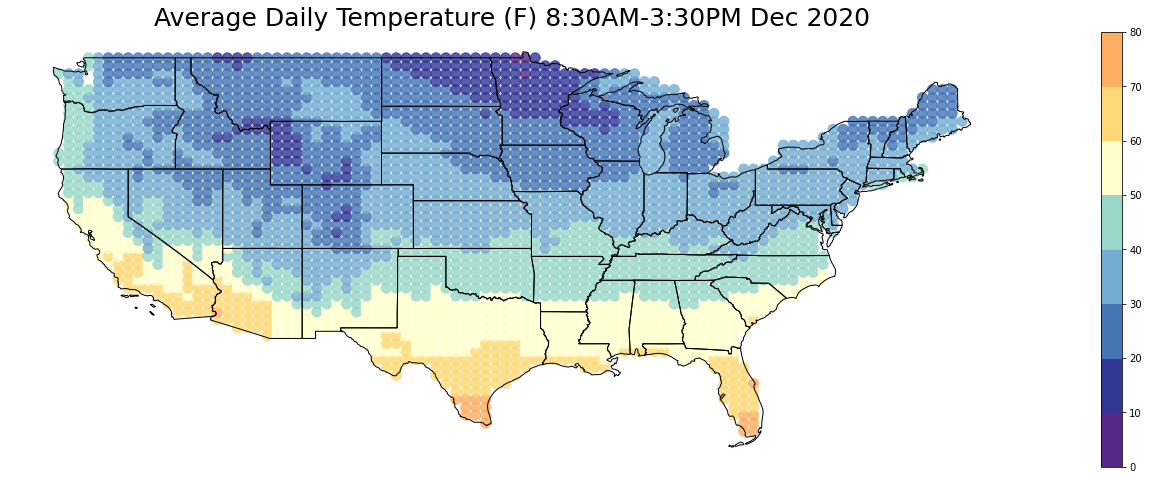

In [19]:
plot_map(constricted_gdf, contenental_states, 
         'average_windchill', colors, 
         'Average Daily Temperature', 'Dec 2020')

In [331]:
tl = [1,2,3]
[0] + tl

[0, 1, 2, 3]

[-10.0, -0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 70.0]
['#2d004b', '#542788', '#313695', '#4575b4', '#74add1', '#99d8c9', '#ffffcc', '#fed976', '#feb24c', '#feb24c']
-4.0650961205266745
70.42641703944055


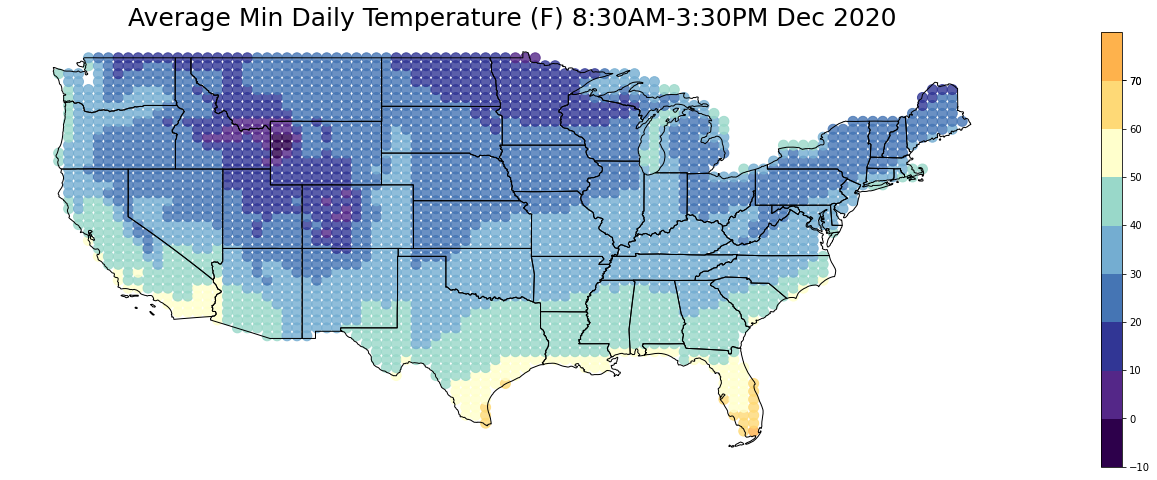

In [505]:
plot_map(constricted_gdf, contenental_states, 'average_min_daily_temp', colors,
        'Average Min Daily Temperature', 'Dec 2020')

KeyError: -50.0

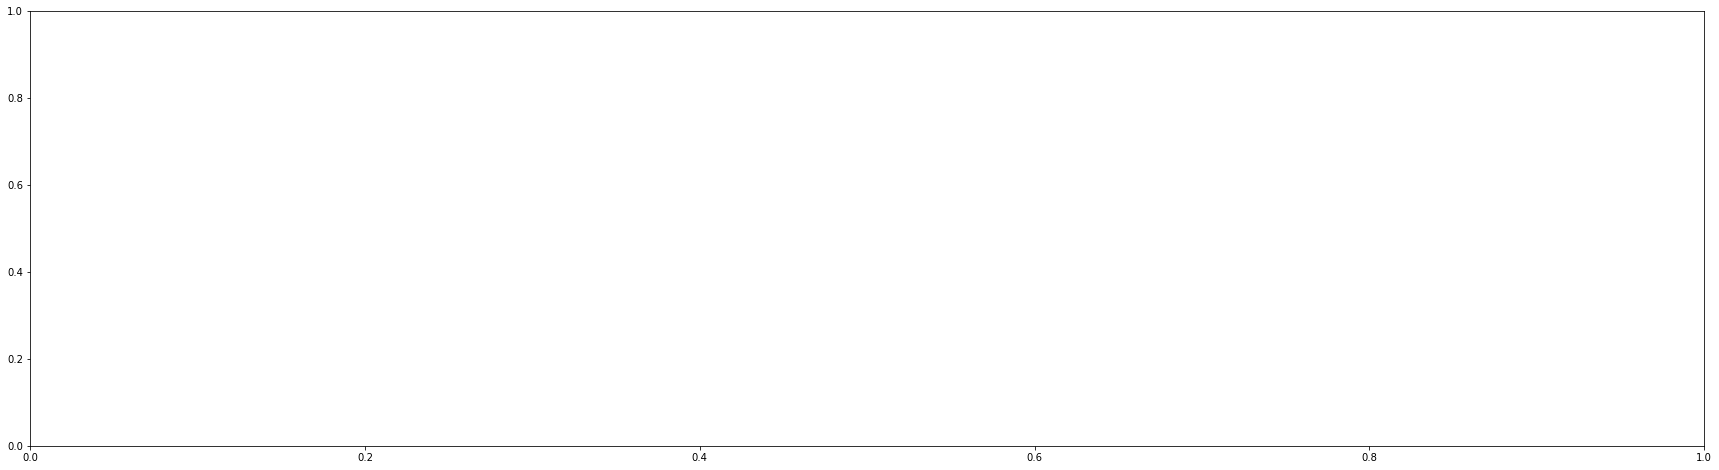

In [334]:
#only works for temperatures I've planned for! 
plot_map(constricted_gdf, contenental_states, 'min_min_daily_windchill', colors)

In [336]:
constricted_gdf['min_min_daily_temp'].min()

-35.272758789062465

## School District
Just have unified dists and elemntary (missing secondary, but it's too many lines already)

In [143]:
elementary_file = os.path.join(data_folder, 'cb_2019_us_elsd_500k/cb_2019_us_elsd_500k.shp')
elementary_dist = geopandas.read_file(elementary_file)

In [146]:
unified_file = os.path.join(data_folder, 'cb_2019_us_unsd_500k/cb_2019_us_unsd_500k.shp')
unified_dist = geopandas.read_file(unified_file)

In [150]:
unified_dist['STATEFP'].head()

0    42
1    27
2    29
3    01
4    17
Name: STATEFP, dtype: object

In [151]:
state_fips = ['02', '15', '60', '66', '69', '72', '78']
contenental_unified_dist = unified_dist[~unified_dist['STATEFP'].isin(state_fips)]
#state_test.head()

In [141]:
gdf.crs

'epsg:4269'

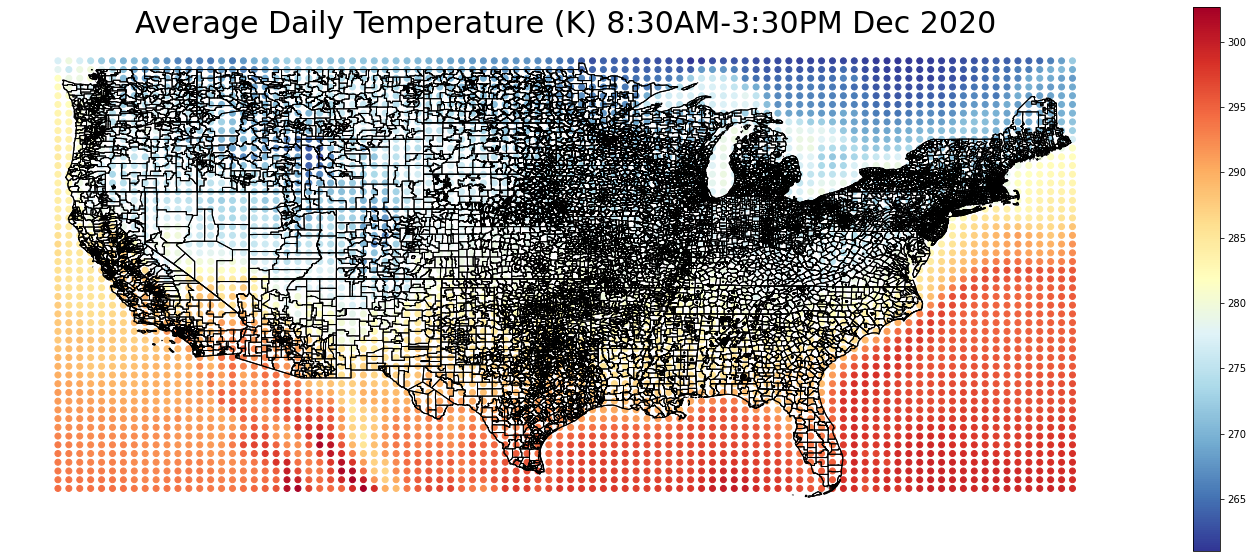

In [153]:
fig, ax = plt.subplots(figsize=(25,10))
#contenental_states.plot(ax=ax, color = 'none', edgecolor='black')
gdf.plot(ax=ax, column = 'average_temp', cmap = 'RdYlBu_r', legend=True)
elementary_dist.plot(ax=ax, color = 'none', edgecolor='black')
contenental_unified_dist.plot(ax=ax, color = 'none', edgecolor='black')
contenental_states.plot(ax=ax, color = 'none', edgecolor='black')



ax.axis('off')
ax.set_title('Average Daily Temperature (K) 8:30AM-3:30PM Dec 2020',
            size=30);

## Try interactive

In [27]:
from bokeh.palettes import RdYlBu11 as palette

In [31]:
#from bokeh.palettes import RdYlBu11 as palette
#color_mapper = LogColorMapper(palette=palette)

#from matplotlib import cm,colors
#plot_height=10, plot_width = 12,
plot = figure(plot_height = 300,
              tooltips=[("value", "$color:fill_color"), ("x", "$x"),("y", "$y")])
#gdf.plot(ax = plot, column = 'average_temp', cmap = 'RdYlBu_r', legend=True)
#plot.vbar(constricted_gdf['average_temp'], top = constricted_gdf['average_temp'], width = 0.8)
plot.circle(constricted_gdf['lon'], constricted_gdf['lat'], 
            fill_color = constricted_gdf['average_windchill'])#,'transform': color_mapper})
#fill_color={'field': 'pop_km2', 'transform': color_mapper},
#, palette = cm.get_cmap("jet"))#, cmap = 'RdYlBu_r')#, legend=True)
#plot.line(contenental_states['geometry'])
#contenental_states.plot(ax=ax, color = 'none', edgecolor='black')



show(plot)

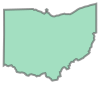

In [618]:
contenental_states['geometry'][3]



In [20]:
from bokeh.models import ColumnDataSource, LogColorMapper

In [21]:
#from https://kodu.ut.ee/~kmoch/geopython2018/lessons/L5/interactive-map-bokeh.html

def getPolyCoords(row, geom, coord_type):
    """Returns the coordinates ('x' or 'y') of edges of a Polygon exterior"""

    # Parse the exterior of the coordinate
    try:
        exterior = row[geom].exterior
        if coord_type == 'x':
        # Get the x coordinates of the exterior
            return list( exterior.coords.xy[0] )
        elif coord_type == 'y':
        # Get the y coordinates of the exterior
            return list( exterior.coords.xy[1] )
    

    except AttributeError:
        print('yup')
    
 

In [22]:
contenental_states['x'] = contenental_states.apply(getPolyCoords, geom='geometry', coord_type='x', axis=1)
contenental_states['y'] = contenental_states.apply(getPolyCoords, geom='geometry', coord_type='y', axis=1)
#grid[['x', 'y']].head(2)

yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup


/Users/Sarah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/Sarah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [637]:
print(contenental_states['geometry'][0][0].exterior)

LINEARRING (-123.237148 48.683466, -123.070427 48.699971, -123.019699 48.721312, -122.979519 48.781702, -122.937925 48.790315, -122.818436 48.744629, -122.743049 48.661991, -122.79901 48.60468299999999, -122.771206 48.56242599999999, -122.779124 48.508911, -122.817912 48.483888, -122.803521 48.428748, -122.874135 48.41819599999999, -122.928004 48.439966, -123.039156 48.460003, -123.141478 48.505291, -123.20268 48.590214, -123.237148 48.683466)


In [23]:
g_df = contenental_states.drop('geometry', axis=1).copy()
gsource = ColumnDataSource(g_df)

In [24]:
p = figure(plot_height = 300)

# Plot grid
p.patches('x', 'y', source=gsource, fill_color = None)

show(p)

In [32]:

#color_mapper = LogColorMapper(palette=palette)

plot = figure(plot_height = 300,
              tooltips=[("value", "$color:fill_color"), ("x", "$x"),("y", "$y")])

plot.patches('x', 'y', source=gsource, fill_color = None)


plot.circle(constricted_gdf['lon'], constricted_gdf['lat'], 
            fill_color = constricted_gdf['average_windchill'])#,'transform': color_mapper})


show(plot)